In [147]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.cross_validation import  train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [148]:
allemp=pd.read_csv("all_employees.csv")

### Feature Engineering

* Convert department levels to numbers. As the lower the department the lower their salaries would be. Hence, the initial ranking needs to be present in the numeric. *Same is done for degree_level*
* Also, We removed the CEO, as it might act as an outlier.

In [149]:
#Convert categories to ordered numerics
level_types = ['IC','MM',"D","VP","E","CEO"]
allemp['level_num'] = allemp.level.astype("category",ordered=True,categories=types).cat.codes
edu_types = ['High_School','Bachelor','Master','PhD']
allemp['degree_num'] = allemp.degree_level.astype("category",ordered=True,categories=edu_types).cat.codes

#Removing Ceo
allemp = allemp[allemp['level'] != 'CEO']

In [150]:
#Convert Gender to dummies
allemp = pd.get_dummies(allemp, columns=['sex','dept'])


In [151]:
allemp.head()

,employee_id,signing_bonus,salary,degree_level,yrs_experience,boss_id,level,n_subordinates,level_num,degree_num,sex_F,sex_M,dept_HR,dept_engineering,dept_marketing,dept_sales
0,138719,0,273.0,Master,2,43602,IC,0,0,2,0,1,0,1,0,0
1,3192,0,301.0,Bachelor,1,87847,IC,0,0,1,1,0,0,0,0,1
2,114657,0,261.0,Master,2,180854,IC,0,0,2,1,0,0,0,0,1
3,29039,0,86.0,High_School,4,88370,IC,0,0,0,1,0,1,0,0,0
4,118607,0,126.0,Bachelor,3,23565,IC,0,0,1,1,0,0,0,0,1


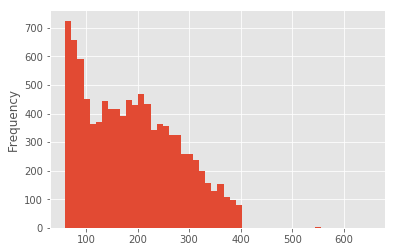

In [152]:
allemp['salary'].plot.hist(bins=50)

In [153]:
#Target variable is highly skewed so we will log transform 


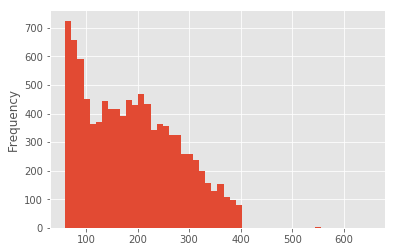

In [154]:
#Target variable is now more symmetrical than before 
allemp['salary'].plot.hist(bins=50)

### Model 

In [155]:
allemp = allemp.drop( ['degree_level','boss_id', 'level','employee_id'], axis = 1)

In [156]:
allemp['salary'] = allemp['salary'].apply(np.log)

*Model 1 - Linear Regression

In [157]:
df = allemp
from sklearn import linear_model
reg=linear_model.LinearRegression()
X_2 = df.drop(['salary'], axis = 1)
y_2= df.salary
X_train, X_test, y_train, y_test = train_test_split(X_2, y_2, test_size=0.2, random_state=101)
reg.fit(X_train,y_train)
predictions =reg.predict(X_test)

In [158]:
#Transform back to original scale
#result = pd.DataFrame({'ytrue': np.exp(y_test),'ypred': np.exp(predictions)})
#print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('RMSE:', np.sqrt(metrics.mean_squared_error(np.exp(y_test), np.exp(predictions))))

RMSE: 74.5319839574


*Model -2 Random Forest 

In [159]:
X_2 = df.drop(['salary'], axis = 1)
y_2= df.salary
X_train, X_test, y_train, y_test = train_test_split(X_2, y_2, test_size=0.2, random_state=101)
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [160]:
predictions_2 =rf.predict(X_test)
print('RMSE:', np.sqrt(metrics.mean_squared_error(np.exp(y_test), np.exp(predictions_2))))

RMSE: 78.0065372456


In [161]:
#Tuning RANDOM Foreset Model 
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 300, num = 4)]
# Number of features to consider at every split
#max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 50, num = 5)]
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
#min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
#bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth, 'min_samples_split': min_samples_split}


In [162]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   22.9s finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': [50, 133, 216, 300], 'max_depth': [5, 16, 27, 38, 50], 'min_samples_split': [2, 5, 10]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring=None, verbose=2)

In [163]:
params = rf_random.best_params_

In [164]:
#make model with tuned parameter
X_3 = df.drop(['salary'], axis = 1)
y_3= df.salary
X_train, X_test, y_train, y_test = train_test_split(X_3, y_3, test_size=0.2, random_state=101)
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor( max_depth=  params['max_depth'],n_estimators= params['n_estimators'])
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [165]:
#Best features 
from tabulate import tabulate
headers = ["name", "score"]
values = sorted(zip(X_train.columns, rf.feature_importances_), key=lambda x: x[1] * -1)
print(tabulate(values, headers, tablefmt="plain"))

name                    score
dept_HR           0.882239
dept_engineering  0.0811734
n_subordinates    0.0195001
yrs_experience    0.00982653
level_num         0.00247826
degree_num        0.00200668
signing_bonus     0.00104244
sex_F             0.000623532
dept_marketing    0.000494397
sex_M             0.000414325
dept_sales        0.000200911


In [77]:
predictions_2 =rf.predict(X_test)
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions_2)))

RMSE: 0.39662023856027206


GBM

In [166]:
#base case error without tuning 
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.ensemble import GradientBoostingRegressor
params = {'n_estimators': 500, 'max_depth': 6,
        'learning_rate': 0.1, 'loss': 'huber','alpha':0.95}
clf = GradientBoostingRegressor(**params).fit(X_train, y_train)

In [167]:
rmse = np.sqrt(mean_squared_error(y_test,clf.predict(X_test)))
rmse

0.41812879505370087

In [168]:
#parameter tuning 
from sklearn.grid_search import GridSearchCV
p_test3 = {'learning_rate':[0.15,0.1,0.05,0.01], 'n_estimators':[100,250,500,750]}

tuning = GridSearchCV(estimator =GradientBoostingRegressor(max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10), 
            param_grid = p_test3, scoring='explained_variance',n_jobs=4,iid=False, cv=5)
tuning.fit(X_train,y_train)
tuning.grid_scores_, tuning.best_params_, tuning.best_score_

c:\anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


([mean: 0.42597, std: 0.01504, params: {'learning_rate': 0.15, 'n_estimators': 100},
  mean: 0.41688, std: 0.01577, params: {'learning_rate': 0.15, 'n_estimators': 250},
  mean: 0.40564, std: 0.01480, params: {'learning_rate': 0.15, 'n_estimators': 500},
  mean: 0.39859, std: 0.01498, params: {'learning_rate': 0.15, 'n_estimators': 750},
  mean: 0.42942, std: 0.01357, params: {'learning_rate': 0.1, 'n_estimators': 100},
  mean: 0.42126, std: 0.01547, params: {'learning_rate': 0.1, 'n_estimators': 250},
  mean: 0.41348, std: 0.01553, params: {'learning_rate': 0.1, 'n_estimators': 500},
  mean: 0.40593, std: 0.01516, params: {'learning_rate': 0.1, 'n_estimators': 750},
  mean: 0.43300, std: 0.01431, params: {'learning_rate': 0.05, 'n_estimators': 100},
  mean: 0.42831, std: 0.01438, params: {'learning_rate': 0.05, 'n_estimators': 250},
  mean: 0.42244, std: 0.01533, params: {'learning_rate': 0.05, 'n_estimators': 500},
  mean: 0.41823, std: 0.01561, params: {'learning_rate': 0.05, 'n_est

In [170]:
#input parameter from previous chunk - learning rate and n_estimators
p_test2 = {'max_depth':[2,3,4,5,6,7] }
tuning = GridSearchCV(estimator =GradientBoostingRegressor(learning_rate=0.01,n_estimators=500,max_features='sqrt'), 
            param_grid = p_test2, scoring='explained_variance',n_jobs=4,iid=False, cv=5)
tuning.fit(X_train,y_train)
tuning.grid_scores_, tuning.best_params_, tuning.best_score_

([mean: 0.43148, std: 0.01380, params: {'max_depth': 2},
  mean: 0.43355, std: 0.01402, params: {'max_depth': 3},
  mean: 0.43273, std: 0.01392, params: {'max_depth': 4},
  mean: 0.43112, std: 0.01342, params: {'max_depth': 5},
  mean: 0.42781, std: 0.01330, params: {'max_depth': 6},
  mean: 0.42313, std: 0.01352, params: {'max_depth': 7}],
 {'max_depth': 3},
 0.43355478065908626)

In [171]:
#Evaluation on test set 
#input max depth optimal value from previous chunk which is 2 
model1 = GradientBoostingRegressor(learning_rate=0.05, n_estimators=100,max_depth=3)
model1.fit(X_train,y_train)
rmse2 = np.sqrt(mean_squared_error(y_test,model1.predict(X_test)))
rmse2

0.40062447277350932

In [173]:
#Best features 
from tabulate import tabulate
headers = ["name", "score"]
values = sorted(zip(X_train.columns, model1.feature_importances_), key=lambda x: x[1] * -1)
print(tabulate(values, headers, tablefmt="plain"))

name                   score
dept_HR           0.600466
n_subordinates    0.125886
yrs_experience    0.105513
dept_engineering  0.0540501
degree_num        0.0455583
signing_bonus     0.0236829
dept_marketing    0.0211529
level_num         0.00903109
sex_F             0.00810402
sex_M             0.00406078
dept_sales        0.00249488


Revised Linear Regressor with best features from Random Forest 

In [174]:
X_train.level.value_counts()


AttributeError: 'DataFrame' object has no attribute 'level'